Let's create a database, it'll have 3 tables:
- one for the posts themselves, there i'll store id, date, length, text and lemmatized text of the post
- another one for comments, there i'll store post id, length, text, lemmatized text, author id of the comment
- third one for the authors and their sociolinguistic parameters: id, city, date of birth, number of posts on the wall

In [3]:
import sqlite3

In [4]:
conn = sqlite3.connect('hw.db')

In [5]:
c = conn.cursor() 

In [135]:
c.execute("CREATE TABLE IF NOT EXISTS posts1(post_id integer, date integer, length integer, text text, lemmatized text text)")

In [143]:
c.execute("CREATE TABLE IF NOT EXISTS comments1(post_id integer, author_id integer, length integer, text text, lemmatized_text text)")

In [106]:
c.execute("CREATE TABLE IF NOT EXISTS users1(author_id integer, city text, bdate text, followers_count integer)")

Now the database should be filled with data basically

In [65]:
import requests

collecting posts

In [137]:
endpoint = "api.vk.com/method"
method = "wall.get"
access_token = "d0629f88d0629f88d0629f88bad0088a04dd062d0629f888cdb5b9bfd4d895fcdad86bd"
params = "domain=apiclub&count=100"
offset = 0
posts = []
while True:
  url = "https://{endpoint}/{method}?{params}&v=5.52&access_token={token}&offset={offset}".format(endpoint=endpoint, method=method, token=access_token, params=params, offset=offset)
  result = requests.get(url).json()
  count = result['response']['count']
  posts += result['response']['items']
  print(len(posts))
  offset += 100
  if count <= offset:
    break

100
140


In [139]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [140]:
import re, os
from datetime import datetime

getting posts

In [141]:
for post in posts:
    post_id = post['id']
    date = post['date']
    #date = datetime.utcfromtimestamp(date).strftime('%Y-%m-%d %H:%M:%S')
    text = post['text']
    length = len(text.split())
    lem_text = ''
    clean_text = re.sub('[^А-ЯЁа-яё]', ' ', text)
    cleaned_text = clean_text.lower()
    clean_text = clean_text.split()
    for word in clean_text:
        lemma = morph.parse(word)[0][2]
        lemma = lemma + ' '
        lem_text += lemma
        
    c.execute("INSERT INTO posts1 VALUES (?, ?, ?, ?, ?)", (post_id, date, length, cleaned_text, lem_text))
    conn.commit()

getting comments

In [144]:
for post in posts:
    post_id = post['id']
    endpoint = "api.vk.com/method"
    method = "wall.getComments"
    access_token = "d0629f88d0629f88d0629f88bad0088a04dd062d0629f888cdb5b9bfd4d895fcdad86bd"
    params = "owner_id=-1&"
    offset = 0 
    param2 = 'count=10&'
    comments = []
    while True:
      url = "https://{endpoint}/{method}?{params}post_id={post_id}&{count}v=5.52&access_token={token}&offset={offset}&preview_length=0".format(endpoint=endpoint, method=method, token=access_token, params=params, post_id=post_id, offset=offset, count=param2)
      result = requests.get(url).json()
      count = result['response']['count']
      comments += result['response']['items']
      offset += 100
      if count <= offset:
        break
    for comment in comments:
        
        post_id = post['id']
        text = comment['text']
        author_id = comment['from_id']
        text = text.lower()
        if text == '':
            continue
        cleaned_text = re.sub('[^А-Яа-яЁё]', ' ', text)
        length = len(cleaned_text.split())
        lem_text = ''
        for word in cleaned_text.split():
            lemma = morph.parse(word)[0][2]
            lemma = lemma + ' '
            lem_text += lemma
        c.execute("INSERT INTO comments1 VALUES (?, ?, ?, ?, ?)", (post_id, author_id, length, cleaned_text, lem_text))
        conn.commit()
        

In [ ]:
c.execute('SELECT * FROM comments ORDER BY author_id')
users = users1 = c.fetchall()


getting user info

In [39]:
c.execute('SELECT * FROM comments ORDER BY author_id')
author_ids = []
for entry in (c.fetchall()):
    author_id = entry[1]
    author_ids.append(author_id)

In [40]:
for author in author_ids:
    if '-' in str(author):
        author_ids.remove(author)
author_ids = set(author_ids)


2779


not all users list city and bdate, only those who do get into the database
also, not all cities have a title i.e. Ivanovo, some only get an id, only users whose cities have a title get into the db

In [107]:
for user in author_ids: 
        endpoint = "api.vk.com/method"
        method = "users.get"
        access_token = "d0629f88d0629f88d0629f88bad0088a04dd062d0629f888cdb5b9bfd4d895fcdad86bd"
        url = "https://{endpoint}/{method}?user_ids={user_ids}&fields=city,bdate,followers_count&v=5.52&access_token={token}".format(endpoint=endpoint, method=method, token=access_token, user_ids=user)
        result = requests.get(url).json()
        author_id = user
        print(result)
        try:
            info = result['response'][0]
            bdate = info['bdate']
            followers_count = info['followers_count']
            city = info['city']['title']
            print(city, bdate, followers)
        except:
            KeyError, IndexError
        c.execute("INSERT INTO users1 VALUES (?, ?, ?, ?)", (author_id, city, bdate, followers_count))
        conn.commit()


{'response': [{'id': 1, 'first_name': 'Pavel', 'last_name': 'Durov', 'bdate': '10.10.1984', 'city': {'id': 2, 'title': 'Saint Petersburg'}, 'followers_count': 5906983}]}
{'response': [{'id': 109133830, 'first_name': 'Lavrenty', 'last_name': 'Selestiysky', 'bdate': '26.1.1994', 'followers_count': 293}]}
{'response': [{'id': 295731207, 'first_name': 'Nina', 'last_name': 'Zhuchkova', 'bdate': '26.3', 'followers_count': 51}]}
{'response': [{'id': 332111880, 'first_name': 'Semyon', 'last_name': 'Dunaev', 'bdate': '21.4', 'city': {'id': 2, 'title': 'Saint Petersburg'}, 'followers_count': 26}]}
{'response': [{'id': 419995657, 'first_name': 'Nastya', 'last_name': 'Strozenko', 'followers_count': 66}]}
{'response': [{'id': 463020038, 'first_name': 'Olga', 'last_name': 'Safronova', 'bdate': '4.4.1972', 'city': {'id': 312, 'title': 'Mytischi'}, 'followers_count': 8}]}
{'response': [{'id': 415309835, 'first_name': 'Mansur', 'last_name': 'Atabaev', 'bdate': '13.11', 'city': {'id': 284, 'title': 'Kar

{'response': [{'id': 1974421, 'first_name': 'Zhora', 'last_name': 'Kornev', 'bdate': '4.12', 'followers_count': 160}]}
{'response': [{'id': 224092309, 'first_name': 'Alexander', 'last_name': 'Zhgun', 'city': {'id': 12987, 'title': 'Kopyl'}, 'followers_count': 23}]}
{'response': [{'id': 287482019, 'first_name': 'Dmitry', 'last_name': 'Serov', 'city': {'id': 60, 'title': 'Kazan'}, 'followers_count': 942}]}
{'response': [{'id': 116998309, 'first_name': 'Vitaly', 'last_name': 'Boyko', 'bdate': '24.9', 'city': {'id': 82, 'title': 'Magnitogorsk'}, 'followers_count': 167}]}
{'response': [{'id': 165699752, 'first_name': 'Vasil', 'last_name': 'Vasilyev', 'bdate': '22.7', 'followers_count': 32}]}
{'response': [{'id': 84000944, 'first_name': 'Sergey', 'last_name': 'Chuchvaga', 'bdate': '23.5.1998', 'city': {'id': 1507326, 'title': 'Liman'}, 'followers_count': 28}]}
{'response': [{'id': 206299320, 'first_name': 'Vyacheslav', 'last_name': 'Polupaltinov', 'bdate': '21.3', 'city': {'id': 99, 'title':

{'response': [{'id': 410517848, 'first_name': 'Maxim', 'last_name': 'Shashkin', 'city': {'id': 109, 'title': 'Penza'}, 'followers_count': 120}]}
{'response': [{'id': 380084571, 'first_name': 'Petite', 'last_name': 'Witch', 'bdate': '19.8', 'followers_count': 27}]}
{'response': [{'id': 172065117, 'first_name': 'Esenia', 'last_name': 'Lyamina', 'bdate': '3.4', 'followers_count': 317}]}
{'response': [{'id': 181387614, 'first_name': 'Nikita', 'last_name': 'Kuzmin', 'bdate': '4.9.2002', 'city': {'id': 151, 'title': 'Ufa'}, 'followers_count': 401}]}
{'response': [{'id': 6898016, 'first_name': 'Kirill', 'last_name': 'Melnichuk', 'bdate': '16.3', 'city': {'id': 1, 'title': 'Moscow'}, 'followers_count': 91}]}
{'response': [{'id': 3948906, 'first_name': 'Bogdan', 'last_name': 'Neizvestny', 'bdate': '12.2', 'city': {'id': 292, 'title': 'Odessa'}, 'followers_count': 227}]}
{'response': [{'id': 8536429, 'first_name': 'Katerina', 'last_name': 'Vishninskaya', 'bdate': '6.8', 'city': {'id': 2, 'title'

{'response': [{'id': 40542693, 'first_name': 'Olexandr', 'last_name': 'Neroda', 'followers_count': 383}]}
{'response': [{'id': 331694566, 'first_name': 'Salavat', 'last_name': 'Asadullin', 'city': {'id': 60, 'title': 'Kazan'}, 'followers_count': 3}]}
{'response': [{'id': 357835241, 'first_name': 'Vityok', 'last_name': 'Ivanov', 'city': {'id': 73, 'title': 'Krasnoyarsk'}, 'followers_count': 188}]}
{'response': [{'id': 217850346, 'first_name': 'Alexandra', 'last_name': 'Bond', 'bdate': '21.3.2000', 'city': {'id': 282, 'title': 'Minsk'}}]}
{'response': [{'id': 310559211, 'first_name': 'Maxim', 'last_name': 'Martynov', 'followers_count': 1}]}
{'response': [{'id': 336036338, 'first_name': 'Ruf', 'last_name': 'Goldfeyn', 'deactivated': 'deleted'}]}
{'response': [{'id': 135741942, 'first_name': 'Roman', 'last_name': 'Antipov', 'bdate': '18.11', 'city': {'id': 458, 'title': 'Berlin'}, 'followers_count': 152}]}
{'response': [{'id': 306086397, 'first_name': 'Nikita', 'last_name': 'Razin', 'bdate

{'response': [{'id': 300950172, 'first_name': 'Ksyusha', 'last_name': 'Bezborodova', 'bdate': '2.10.2003', 'followers_count': 301}]}
{'response': [{'id': 315712162, 'first_name': 'Yarik', 'last_name': 'Strelchenko', 'followers_count': 12}]}
{'response': [{'id': 85721764, 'first_name': 'Konstantin', 'last_name': 'Platonov', 'bdate': '25.6', 'city': {'id': 21338, 'title': 'Heppenheim (Bergstraße)'}, 'followers_count': 55}]}
{'response': [{'id': 331276964, 'first_name': 'Lelya', 'last_name': 'Agatova', 'followers_count': 355}]}
{'response': [{'id': 165208742, 'first_name': 'Alla', 'last_name': 'Turovskaya', 'city': {'id': 2, 'title': 'Saint Petersburg'}, 'followers_count': 249}]}
{'response': [{'id': 194200230, 'first_name': 'Dmitry', 'last_name': 'Vasilyev'}]}
{'response': [{'id': 277815976, 'first_name': 'Ulukbek', 'last_name': 'Mambetaliev', 'bdate': '20.4.1998', 'city': {'id': 1910746, 'title': 'Kemin'}, 'followers_count': 0}]}
{'response': [{'id': 91980459, 'first_name': 'Elizaveta',

{'response': [{'id': 369189748, 'first_name': 'Svetlana', 'last_name': 'Sadykova', 'bdate': '4.8', 'city': {'id': 1012757, 'title': 'Psikhointernat'}}]}
{'response': [{'id': 71312245, 'first_name': 'Alexey', 'last_name': 'Belyaev', 'bdate': '25.10.1991', 'city': {'id': 2, 'title': 'Saint Petersburg'}, 'followers_count': 606}]}
{'response': [{'id': 354796407, 'first_name': 'Sasha', 'last_name': 'Vinnikov', 'bdate': '6.12.2002', 'city': {'id': 1711829, 'title': 'Dortmund'}, 'followers_count': 22}]}
{'response': [{'id': 415089530, 'first_name': 'Aysylu', 'last_name': 'Miftakhova', 'bdate': '18.7.1991', 'city': {'id': 60, 'title': 'Kazan'}, 'followers_count': 129}]}
{'response': [{'id': 348849019, 'first_name': 'Denis', 'last_name': 'Vinogradov', 'bdate': '24.2.1978', 'city': {'id': 536, 'title': 'Pavlodar'}, 'followers_count': 4}]}
{'response': [{'id': 2933629, 'first_name': 'Alexey', 'last_name': 'Grigoryev', 'deactivated': 'deleted'}]}
{'response': [{'id': 252461952, 'first_name': 'Alex

{'response': [{'id': 434816057, 'first_name': 'Vitaly', 'last_name': 'Revunov', 'bdate': '3.10', 'city': {'id': 264, 'title': 'Salavat'}, 'followers_count': 78}]}
{'response': [{'id': 10232896, 'first_name': 'Vladislav', 'last_name': 'Boyarkin', 'city': {'id': 99, 'title': 'Novosibirsk'}, 'followers_count': 2}]}
{'response': [{'id': 441812036, 'first_name': 'Evlampy', 'last_name': 'Ryba', 'bdate': '30.9', 'city': {'id': 220, 'title': 'Tallinn'}, 'followers_count': 78}]}
{'response': [{'id': 296961093, 'first_name': 'Anton', 'last_name': 'Lisitsky', 'bdate': '15.8.1981', 'city': {'id': 117, 'title': 'Ramenskoe'}, 'followers_count': 96}]}
{'response': [{'id': 341451845, 'first_name': 'Avgust', 'last_name': 'Bessmertny', 'followers_count': 81}]}
{'response': [{'id': 526468173, 'first_name': 'Raisa', 'last_name': 'Korzhakova', 'deactivated': 'banned'}]}
{'response': [{'id': 397280339, 'first_name': 'Georgy', 'last_name': 'Nikonov', 'bdate': '14.9.2004', 'followers_count': 32}]}
{'response'

{'response': [{'id': 406627586, 'first_name': 'Alexander', 'last_name': 'Tetsky', 'bdate': '6.2.1996', 'city': {'id': 1507351, 'title': 'Irmino (Teplogorsk)'}, 'followers_count': 204}]}
{'response': [{'id': 6759685, 'first_name': 'Vilka', 'last_name': 'Shults', 'bdate': '9.4', 'city': {'id': 87, 'title': 'Murmansk'}, 'followers_count': 84}]}
{'response': [{'id': 121120008, 'first_name': 'Sergey', 'last_name': 'Ivanov', 'followers_count': 1}]}
{'response': [{'id': 348005649, 'first_name': 'Sergey', 'last_name': 'Nechaev', 'bdate': '22.8.1902'}]}
{'response': [{'id': 421225745, 'first_name': 'Irina', 'last_name': 'Irinina'}]}
{'response': [{'id': 447022353, 'first_name': 'Denis', 'last_name': 'Bakhshian', 'bdate': '6.1', 'city': {'id': 139, 'title': 'Taganrog'}, 'followers_count': 7}]}
{'response': [{'id': 433866005, 'first_name': 'Nikolay', 'last_name': 'Redko', 'bdate': '22.7.2000', 'city': {'id': 60, 'title': 'Kazan'}, 'followers_count': 121}]}
{'response': [{'id': 174859543, 'first_n

{'response': [{'id': 50111915, 'first_name': 'Elena', 'last_name': 'Chernova', 'followers_count': 0}]}
{'response': [{'id': 328263083, 'first_name': 'Stas', 'last_name': 'Alexandrov', 'bdate': '8.8', 'followers_count': 110}]}
{'response': [{'id': 441460142, 'first_name': 'Alexander', 'last_name': 'Dolgov', 'bdate': '12.7.1997', 'followers_count': 9}]}
{'response': [{'id': 421365167, 'first_name': 'Kazimir', 'last_name': 'Glukhovsky', 'deactivated': 'deleted'}]}
{'response': [{'id': 258008502, 'first_name': 'Viktoria', 'last_name': 'Garpel', 'bdate': '2.7', 'city': {'id': 427, 'title': 'Kherson'}, 'followers_count': 4}]}
{'response': [{'id': 44041656, 'first_name': 'Dmitry', 'last_name': 'Semyonov', 'bdate': '1.4', 'city': {'id': 2, 'title': 'Saint Petersburg'}}]}
{'response': [{'id': 169289148, 'first_name': 'Feb', 'last_name': 'Dex'}]}
{'response': [{'id': 406357436, 'first_name': 'Masha', 'last_name': 'Malykh', 'bdate': '20.5.2003', 'city': {'id': 1154279, 'title': 'Artemovsky'}}]}
{

{'response': [{'id': 461489764, 'first_name': 'Eva', 'last_name': 'Ivanchuk', 'deactivated': 'banned'}]}
{'response': [{'id': 9004645, 'first_name': 'Nikolay', 'last_name': 'Pukishev', 'bdate': '21.12.1992', 'followers_count': 48}]}
{'response': [{'id': 54863462, 'first_name': 'Anton', 'last_name': 'Pavlov', 'bdate': '24.8', 'city': {'id': 1, 'title': 'Moscow'}, 'followers_count': 77}]}
{'response': [{'id': 314689127, 'first_name': 'Dmitry', 'last_name': 'Romanov', 'deactivated': 'deleted'}]}
{'response': [{'id': 424076901, 'first_name': 'Dima', 'last_name': 'Kozlov', 'bdate': '29.12.1988', 'city': {'id': 7073, 'title': 'Senno'}}]}
{'response': [{'id': 11093612, 'first_name': 'Andrey', 'last_name': 'Cheptsov', 'bdate': '20.3.1984', 'city': {'id': 1951986, 'title': 'München'}}]}
{'response': [{'id': 71845486, 'first_name': 'Vitaly', 'last_name': 'Ilyin', 'bdate': '14.3', 'city': {'id': 157, 'title': 'Cheboxary'}, 'followers_count': 117}]}
{'response': [{'id': 448734831, 'first_name': 'D

{'response': [{'id': 269117187, 'first_name': 'Irina', 'last_name': 'Dziova', 'bdate': '10.12.2001', 'followers_count': 90}]}
{'response': [{'id': 377808647, 'first_name': 'Masha', 'last_name': 'Chirkova', 'deactivated': 'deleted'}]}
{'response': [{'id': 453338889, 'first_name': 'Edvard', 'last_name': 'Cherny', 'bdate': '3.6', 'city': {'id': 1164, 'title': 'Albuquerque'}, 'followers_count': 114}]}
{'response': [{'id': 255698713, 'first_name': 'Ella', 'last_name': 'Smirnova', 'bdate': '26.7', 'city': {'id': 56, 'title': 'Izhevsk'}, 'followers_count': 304}]}
{'response': [{'id': 99772190, 'first_name': 'Maxim', 'last_name': 'Trotsun', 'followers_count': 54}]}
{'response': [{'id': 187672350, 'first_name': 'Oksana', 'last_name': 'Volk', 'bdate': '15.8.2001', 'city': {'id': 3806, 'title': 'Pushkinskie Gory'}, 'followers_count': 0}]}
{'response': [{'id': 287778591, 'first_name': 'Khasen', 'last_name': 'Ismagulov', 'deactivated': 'deleted'}]}
{'response': [{'id': 353068833, 'first_name': 'Mar

{'response': [{'id': 201172912, 'first_name': 'Liza', 'last_name': 'Savinykh', 'bdate': '24.4', 'city': {'id': 110, 'title': 'Perm'}, 'followers_count': 199}]}
{'response': [{'id': 436602804, 'first_name': 'Snezha', 'last_name': 'Kovalyova', 'bdate': '17.3', 'followers_count': 256}]}
{'response': []}
{'response': [{'id': 204556225, 'first_name': 'Denis', 'last_name': 'Misailov', 'bdate': '13.3', 'city': {'id': 1, 'title': 'Moscow'}, 'followers_count': 146}]}
{'response': [{'id': 256739266, 'first_name': 'Vika', 'last_name': 'Guseynova', 'bdate': '1.2', 'city': {'id': 96, 'title': 'Nizhniy Tagil'}, 'followers_count': 158}]}
{'response': [{'id': 476104643, 'first_name': 'Viktor', 'last_name': 'Tsveyg', 'city': {'id': 1905282, 'title': 'Valmiera'}, 'followers_count': 7}]}
{'response': [{'id': 2041800, 'first_name': 'Timur', 'last_name': 'Bulachyov', 'bdate': '15.1.1986', 'city': {'id': 2, 'title': 'Saint Petersburg'}}]}
{'response': [{'id': 13281225, 'first_name': 'Rostislav', 'last_name'

{'response': [{'id': 14321775, 'first_name': 'Egor', 'last_name': 'Kozlov', 'bdate': '27.3', 'followers_count': 20}]}
{'response': [{'id': 63981684, 'first_name': 'Nicholas', 'last_name': 'Merx', 'city': {'id': 3170, 'title': 'Rovno'}, 'followers_count': 10}]}
{'response': [{'id': 36300919, 'first_name': 'Dmitry', 'last_name': 'Tinaev', 'bdate': '12.11.1990', 'city': {'id': 1, 'title': 'Moscow'}, 'followers_count': 351}]}
{'response': [{'id': 22472826, 'first_name': 'Andrey', 'last_name': 'Nechaev', 'bdate': '25.1', 'city': {'id': 1762, 'title': 'Demyansk'}, 'followers_count': 32}]}
{'response': [{'id': 457304186, 'first_name': 'Evgeny', 'last_name': 'Kurykin', 'bdate': '21.2', 'city': {'id': 10, 'title': 'Volgograd'}, 'followers_count': 67}]}
{'response': [{'id': 349939836, 'first_name': 'Kostya', 'last_name': 'Sozonov', 'followers_count': 63}]}
{'response': [{'id': 322898050, 'first_name': 'Mustafa', 'last_name': 'Osipov', 'bdate': '17.7.2000'}]}
{'response': [{'id': 2893955, 'first_

{'response': [{'id': 490801433, 'first_name': 'Apelsin', 'last_name': 'Egorova', 'bdate': '10.11.1940', 'city': {'id': 72, 'title': 'Krasnodar'}, 'followers_count': 3}]}
{'response': [{'id': 331049244, 'first_name': 'Arseny', 'last_name': 'Kel', 'bdate': '11.10.2002', 'city': {'id': 153, 'title': 'Khabarovsk'}, 'followers_count': 51}]}
{'response': [{'id': 23955742, 'first_name': 'Alexey', 'last_name': 'Tarasov', 'followers_count': 4}]}
{'response': [{'id': 378382624, 'first_name': 'Valentin', 'last_name': 'Nikitin', 'deactivated': 'banned'}]}
{'response': [{'id': 293718305, 'first_name': 'Seryozha', 'last_name': 'Kot', 'bdate': '1.8', 'followers_count': 416}]}
{'response': [{'id': 488491298, 'first_name': 'Ruslan', 'last_name': 'Chavez', 'bdate': '23.3', 'city': {'id': 1956352, 'title': 'Caracas'}, 'followers_count': 14260}]}
{'response': [{'id': 95480099, 'first_name': 'Sanya', 'last_name': 'Vishnyakov', 'followers_count': 4468}]}
{'response': [{'id': 32581942, 'first_name': 'Evgeny'

{'response': [{'id': 453200332, 'first_name': 'Zheka', 'last_name': 'Yantsevich', 'deactivated': 'banned'}]}
{'response': [{'id': 190928, 'first_name': 'Pavel', 'last_name': 'Shashanov', 'city': {'id': 2, 'title': 'Saint Petersburg'}, 'followers_count': 1}]}
{'response': [{'id': 467102161, 'first_name': 'Katya', 'last_name': 'Kot', 'bdate': '4.4', 'city': {'id': 151, 'title': 'Ufa'}, 'followers_count': 11}]}
{'response': [{'id': 475040208, 'first_name': 'Ksyusha', 'last_name': 'Karmanova', 'bdate': '12.5', 'followers_count': 79}]}
{'response': [{'id': 188197334, 'first_name': 'Nyurguyana', 'last_name': 'Ivanova', 'bdate': '29.1', 'city': {'id': 168, 'title': 'Yakutsk'}, 'followers_count': 127}]}
{'response': [{'id': 11061719, 'first_name': 'Danil', 'last_name': 'Dushkin', 'bdate': '16.2', 'city': {'id': 42, 'title': 'Voronezh'}, 'followers_count': 931}]}
{'response': [{'id': 216345046, 'first_name': 'Alexey', 'last_name': 'Tumanov', 'bdate': '24.5', 'city': {'id': 158, 'title': 'Chelya

{'response': [{'id': 257444504, 'first_name': 'Maxim', 'last_name': 'Tarasov', 'bdate': '14.1', 'city': {'id': 649, 'title': 'Grodno'}, 'followers_count': 113}]}
{'response': [{'id': 443443872, 'first_name': 'Vladislav', 'last_name': 'Ryzhov', 'bdate': '21.12', 'city': {'id': 134, 'title': 'Stavropol'}, 'followers_count': 37}]}
{'response': [{'id': 63703713, 'first_name': 'Sergey', 'last_name': 'Volodin', 'bdate': '16.2', 'city': {'id': 2, 'title': 'Saint Petersburg'}, 'followers_count': 1182}]}
{'response': [{'id': 3943076, 'first_name': 'Sergey', 'last_name': 'Solozhentsev', 'bdate': '22.11.1982', 'city': {'id': 282, 'title': 'Minsk'}, 'followers_count': 110}]}
{'response': [{'id': 320924327, 'first_name': 'Stanislav', 'last_name': 'Ivanovsky'}]}
{'response': [{'id': 408881832, 'first_name': 'Eldar', 'last_name': 'Yun', 'deactivated': 'deleted'}]}
{'response': [{'id': 304351913, 'first_name': 'Viktoria', 'last_name': 'Okotchik', 'bdate': '19.11', 'followers_count': 81}]}
{'response':

{'response': [{'id': 377580343, 'first_name': 'Sokhibchon', 'last_name': 'Boboev', 'bdate': '6.12', 'city': {'id': 1937246, 'title': 'Dushanbe'}, 'followers_count': 2}]}
{'response': [{'id': 424741688, 'first_name': 'Diky', 'last_name': 'Ublyudok'}]}
{'response': [{'id': 445459255, 'first_name': 'Artyom', 'last_name': 'Bezdushny', 'bdate': '6.12.1996', 'followers_count': 3}]}
{'response': [{'id': 144976698, 'first_name': 'Alexey', 'last_name': 'Artemyev', 'bdate': '17.6.1991', 'followers_count': 26}]}
{'response': [{'id': 476621625, 'first_name': 'Positive', 'last_name': 'Future', 'followers_count': 2}]}
{'response': [{'id': 32410431, 'first_name': 'Yury', 'last_name': 'Khuls', 'bdate': '12.8'}]}
{'response': [{'id': 349571904, 'first_name': 'Diana', 'last_name': 'Mayakovskaya', 'followers_count': 706}]}
{'response': [{'id': 445033279, 'first_name': 'Vitalik', 'last_name': 'Plamenev', 'deactivated': 'deleted'}]}
{'response': [{'id': 339503938, 'first_name': 'Svetlana', 'last_name': 'Pe

{'response': [{'id': 508546007, 'first_name': 'Svetlana-Ionova', 'last_name': 'Ionova', 'deactivated': 'banned'}]}
{'response': [{'id': 250448860, 'first_name': 'Egor', 'last_name': 'Yakovlev', 'city': {'id': 2, 'title': 'Saint Petersburg'}, 'followers_count': 36}]}
{'response': [{'id': 372083677, 'first_name': 'Sonya', 'last_name': 'Belkova', 'deactivated': 'banned'}]}
{'response': [{'id': 460565468, 'first_name': 'Evgenia', 'last_name': 'Pavlova', 'bdate': '22.12', 'city': {'id': 156, 'title': 'Chaykovsky'}, 'followers_count': 125}]}
{'response': [{'id': 43142112, 'first_name': 'Viktoria', 'last_name': 'Brusnitsyna', 'followers_count': 519}]}
{'response': [{'id': 61189090, 'first_name': 'Anastasia', 'last_name': 'Nazarova'}]}
{'response': [{'id': 440429538, 'first_name': 'Lera', 'last_name': 'Sibirskaya', 'bdate': '27.6'}]}
{'response': [{'id': 440314852, 'first_name': 'Anastasia', 'last_name': 'Moiseeva', 'bdate': '24.10.2004', 'city': {'id': 146, 'title': 'Tula'}, 'followers_count'

{'response': [{'id': 415730800, 'first_name': 'Vladislav', 'last_name': 'Mirny', 'bdate': '24.5', 'city': {'id': 1, 'title': 'Moscow'}}]}
{'response': [{'id': 311127153, 'first_name': 'Aysaule', 'last_name': 'Bolatova', 'followers_count': 0}]}
{'response': [{'id': 171412594, 'first_name': 'Yana', 'last_name': 'Vasilyeva', 'bdate': '18.8.1985', 'city': {'id': 3992, 'title': 'Gubakha'}, 'followers_count': 284}]}
{'response': [{'id': 93760629, 'first_name': 'Vladimir', 'last_name': 'Kalinin', 'city': {'id': 119, 'title': 'Rostov-on-Don'}}]}
{'response': [{'id': 203050103, 'first_name': 'One', 'last_name': 'Aloner', 'bdate': '20.2.1992', 'city': {'id': 2480, 'title': 'Göteborg'}}]}
{'response': [{'id': 446237819, 'first_name': 'Dima', 'last_name': 'Morozov', 'bdate': '20.1.1982', 'city': {'id': 1343, 'title': 'Porkhov'}, 'followers_count': 39}]}
{'response': [{'id': 423726207, 'first_name': 'Vladimir', 'last_name': 'Vladimirovich', 'followers_count': 44}]}
{'response': [{'id': 287370377, '

{'response': [{'id': 286887195, 'first_name': 'Porfiry', 'last_name': 'Bryansky', 'bdate': '2.2', 'followers_count': 151}]}
{'response': [{'id': 118044, 'first_name': 'Igor', 'last_name': 'Kolchinsky', 'bdate': '22.8', 'city': {'id': 2, 'title': 'Saint Petersburg'}, 'followers_count': 1285}]}
{'response': [{'id': 4295969, 'first_name': 'Alexander', 'last_name': 'Grebenschikov', 'deactivated': 'banned'}]}
{'response': [{'id': 25865506, 'first_name': 'Venya', 'last_name': 'Nikto', 'bdate': '9.8.1991', 'city': {'id': 244, 'title': 'Vitebsk'}, 'followers_count': 76}]}
{'response': [{'id': 28855585, 'first_name': 'Nikolay', 'last_name': 'Kusch', 'followers_count': 0}]}
{'response': [{'id': 258518306, 'first_name': 'Alexander', 'last_name': 'Lepikash', 'city': {'id': 87, 'title': 'Murmansk'}, 'followers_count': 42}]}
{'response': [{'id': 381857062, 'first_name': 'Nadezhda', 'last_name': 'Sakra', 'bdate': '20.10', 'city': {'id': 114, 'title': 'Pskov'}}]}
{'response': [{'id': 303066409, 'first

{'response': [{'id': 3329479, 'first_name': 'Nikolay', 'last_name': 'Kuznetsov', 'bdate': '16.2', 'city': {'id': 5115, 'title': 'Neya'}, 'followers_count': 36}]}
{'response': [{'id': 522751434, 'first_name': 'Fayaz', 'last_name': 'Yakhin', 'city': {'id': 8139, 'title': 'Yanaul'}, 'followers_count': 0}]}
{'response': [{'id': 471993804, 'first_name': 'Vadim', 'last_name': 'Romanov', 'deactivated': 'deleted'}]}
{'response': [{'id': 10268111, 'first_name': 'Alexandr', 'last_name': 'Kovtunov', 'bdate': '14.3', 'followers_count': 196}]}
{'response': [{'id': 269372879, 'first_name': 'Darya', 'last_name': 'Demidkina', 'bdate': '4.9', 'city': {'id': 1032, 'title': 'Polotsk'}, 'followers_count': 110}]}
{'response': [{'id': 210841045, 'first_name': 'Denis', 'last_name': 'Yulushev', 'bdate': '30.9', 'city': {'id': 3996564, 'title': 'Horokanai'}, 'followers_count': 119}]}
{'response': [{'id': 270765529, 'first_name': 'Sasha', 'last_name': 'Volik'}]}
{'response': [{'id': 457371105, 'first_name': 'Ks

{'response': [{'id': 227823201, 'first_name': 'Yulechka', 'last_name': 'Volkova', 'bdate': '1.6.2003', 'city': {'id': 916, 'title': 'Kryvyi Rih'}, 'followers_count': 852}]}
{'response': [{'id': 397618785, 'first_name': 'Minkhyon', 'last_name': 'Khvan', 'bdate': '1.4.1988', 'followers_count': 147}]}
{'response': [{'id': 11226723, 'first_name': 'DELETED', 'last_name': '', 'deactivated': 'deleted'}]}
{'response': [{'id': 423128674, 'first_name': '゙-゙-゙-゙', 'last_name': '゙-゙-゙-゙-゙-゙-゙-゙-゙-゙', 'bdate': '1.5', 'followers_count': 7}]}
{'response': [{'id': 195235433, 'first_name': 'Ivan', 'last_name': 'Olofinsky', 'bdate': '11.6.2000', 'followers_count': 21}]}
{'response': [{'id': 405827177, 'first_name': 'Ilnaz', 'last_name': 'Valeev', 'bdate': '3.1.2004', 'city': {'id': 12690, 'title': 'Buzdyak'}, 'followers_count': 101}]}
{'response': [{'id': 1953388, 'first_name': 'Anyutka', 'last_name': 'Nikiforova', 'bdate': '7.9', 'city': {'id': 1057304, 'title': 'san Barvikha'}}]}
{'response': [{'id': 

{'response': [{'id': 206352149, 'first_name': 'Nikita', 'last_name': 'Matrosov', 'bdate': '22.3', 'followers_count': 0}]}
{'response': [{'id': 127807263, 'first_name': 'Denis', 'last_name': 'Titov', 'bdate': '12.5.1994', 'city': {'id': 787, 'title': 'Desnogorsk'}, 'followers_count': 156}]}
{'response': [{'id': 6926112, 'first_name': 'Artem', 'last_name': 'Chukin', 'bdate': '11.5.1990', 'city': {'id': 158, 'title': 'Chelyabinsk'}, 'followers_count': 7}]}
{'response': [{'id': 487100195, 'first_name': 'Vasily', 'last_name': 'Talimonov', 'bdate': '9.3.1929', 'city': {'id': 1158, 'title': 'Zhitomir'}, 'followers_count': 50}]}
{'response': [{'id': 397095, 'first_name': 'Artyom', 'last_name': 'Grigoryev', 'bdate': '16.4.1991', 'city': {'id': 2, 'title': 'Saint Petersburg'}}]}
{'response': [{'id': 392359721, 'first_name': 'Sonya', 'last_name': 'Makyeyeva', 'bdate': '23.11', 'followers_count': 7}]}
{'response': [{'id': 35213098, 'first_name': 'Stanislav', 'last_name': 'Timofeev', 'bdate': '30.6

{'response': [{'id': 308752294, 'first_name': 'Anastasia', 'last_name': 'Medvedeva', 'deactivated': 'deleted'}]}
{'response': [{'id': 316657576, 'first_name': 'Angelina', 'last_name': 'Suvorova', 'deactivated': 'banned'}]}
{'response': [{'id': 417050537, 'first_name': 'Dmitry', 'last_name': 'Rubin', 'bdate': '3.1.1995', 'city': {'id': 143, 'title': 'Tolyatti'}, 'followers_count': 55}]}
{'response': [{'id': 278302634, 'first_name': 'Viktoria', 'last_name': 'Soboleva', 'followers_count': 7}]}
{'response': [{'id': 302632874, 'first_name': 'Denis', 'last_name': 'Romanov', 'bdate': '17.3', 'followers_count': 262}]}
{'response': [{'id': 215961517, 'first_name': 'Nikita', 'last_name': 'Yurkov', 'bdate': '10.6.1999', 'followers_count': 111}]}
{'response': [{'id': 147509166, 'first_name': 'Dina', 'last_name': 'Dolotina', 'city': {'id': 109, 'title': 'Penza'}, 'followers_count': 197}]}
{'response': [{'id': 316305327, 'first_name': 'Timofey', 'last_name': 'Ivanov', 'bdate': '21.11.1914', 'city': 

{'response': [{'id': 457068652, 'first_name': 'Artur', 'last_name': 'Yakovlev', 'bdate': '7.5.2001', 'city': {'id': 536, 'title': 'Pavlodar'}, 'followers_count': 101}]}
{'response': [{'id': 339128431, 'first_name': 'Nikolay', 'last_name': 'Privalov', 'city': {'id': 1, 'title': 'Moscow'}, 'followers_count': 14}]}
{'response': [{'id': 488534127, 'first_name': 'Yana', 'last_name': 'Karachun', 'bdate': '10.1.2004', 'followers_count': 27}]}
{'response': [{'id': 235581553, 'first_name': 'Nikolay', 'last_name': 'Dontsov', 'bdate': '18.6', 'city': {'id': 60, 'title': 'Kazan'}, 'followers_count': 9}]}
{'response': [{'id': 360018033, 'first_name': 'Ivan', 'last_name': 'Pchelin', 'city': {'id': 66, 'title': 'Kirov'}, 'followers_count': 76}]}
{'response': [{'id': 425005169, 'first_name': 'Mihail', 'last_name': 'Blomfried', 'bdate': '15.5', 'city': {'id': 2510, 'title': 'Alushta'}, 'followers_count': 2367}]}
{'response': [{'id': 427462775, 'first_name': 'Sergey', 'last_name': 'Isupov', 'bdate': '15

{'response': [{'id': 135172359, 'first_name': 'Angelina', 'last_name': 'Laricheva', 'city': {'id': 78, 'title': 'Lipetsk'}, 'followers_count': 361}]}
{'response': [{'id': 310931722, 'first_name': 'Klava', 'last_name': 'Malaya', 'bdate': '24.1', 'city': {'id': 3700, 'title': 'Volgodonsk'}, 'followers_count': 187}]}
{'response': [{'id': 13021455, 'first_name': 'Igor', 'last_name': 'Rusanov', 'bdate': '25.3.1991', 'city': {'id': 39, 'title': 'Vladimir'}, 'followers_count': 2}]}
{'response': [{'id': 459895056, 'first_name': 'Maxim', 'last_name': 'Novikov', 'bdate': '17.4.2002', 'city': {'id': 100, 'title': 'Novouralsk'}, 'followers_count': 135}]}
{'response': [{'id': 349032725, 'first_name': 'Tatka', 'last_name': 'Mokrushina', 'bdate': '13.1.1995', 'followers_count': 1774}]}
{'response': [{'id': 95064344, 'first_name': 'Alexander', 'last_name': 'Khokhlov', 'bdate': '20.4', 'followers_count': 0}]}
{'response': [{'id': 409850136, 'first_name': 'Danil', 'last_name': 'Kot', 'city': {'id': 288,

{'response': [{'id': 253333927, 'first_name': 'Միքայել', 'last_name': 'Ֆրանգուլյան', 'bdate': '7.8.2002', 'followers_count': 256}]}
{'response': [{'id': 395022759, 'first_name': 'Lara', 'last_name': 'Varfolomeeva', 'city': {'id': 1, 'title': 'Moscow'}, 'followers_count': 66}]}
{'response': [{'id': 388936105, 'first_name': 'Dima', 'last_name': 'Khamenkov', 'bdate': '13.5.2003', 'city': {'id': 392, 'title': 'Gomel'}, 'followers_count': 41}]}
{'response': [{'id': 449966509, 'first_name': 'Emirkhan', 'last_name': 'Emirov', 'bdate': '17.6', 'city': {'id': 1661, 'title': 'Washington, D.C.'}}]}
{'response': [{'id': 281891246, 'first_name': 'Mikhail', 'last_name': 'Petrov', 'bdate': '16.2.1999', 'city': {'id': 1503746, 'title': 'Narodichi'}, 'followers_count': 41}]}
{'response': [{'id': 58069425, 'first_name': 'Olga', 'last_name': 'Rau', 'bdate': '8.10.1972', 'city': {'id': 123, 'title': 'Samara'}, 'followers_count': 32}]}
{'response': [{'id': 408252852, 'first_name': 'Stanislav', 'last_name':

{'response': [{'id': 264745554, 'first_name': 'Alexey', 'last_name': 'Maximov', 'bdate': '22.5'}]}
{'response': [{'id': 186004051, 'first_name': 'Yulia', 'last_name': 'Vasnetsova', 'bdate': '17.5.1987', 'city': {'id': 340, 'title': 'Serpukhov'}, 'followers_count': 1008}]}
{'response': [{'id': 368259666, 'first_name': 'Anastasia', 'last_name': 'Orlova', 'deactivated': 'banned'}]}
{'response': [{'id': 4297302, 'first_name': 'Kirill', 'last_name': 'Ivaschenko', 'deactivated': 'deleted'}]}
{'response': [{'id': 414380631, 'first_name': 'Kristina', 'last_name': 'Vorobyova', 'bdate': '31.3', 'city': {'id': 73, 'title': 'Krasnoyarsk'}, 'followers_count': 27}]}
{'response': [{'id': 185430621, 'first_name': 'Nastya', 'last_name': 'Trifonova', 'bdate': '25.5.1997', 'city': {'id': 5803, 'title': 'Temnikov'}, 'followers_count': 537}]}
{'response': [{'id': 44061280, 'first_name': 'Darya', 'last_name': 'Valetova', 'bdate': '9.12.1996', 'city': {'id': 99, 'title': 'Novosibirsk'}, 'followers_count': 12

{'response': [{'id': 431698672, 'first_name': 'Sunatullo', 'last_name': 'Kendzhaew', 'bdate': '26.8.1997', 'city': {'id': 4224710, 'title': 'Klaksvík'}, 'followers_count': 0}]}
{'response': [{'id': 92033781, 'first_name': 'Evgeny', 'last_name': 'Breus', 'city': {'id': 314, 'title': 'Kyiv'}, 'followers_count': 2040}]}
{'response': [{'id': 186700534, 'first_name': 'Pavel', 'last_name': 'Privolny', 'followers_count': 25}]}
{'response': [{'id': 4354807, 'first_name': 'Alexey', 'last_name': 'Dvorkin', 'city': {'id': 1, 'title': 'Moscow'}, 'followers_count': 49}]}
{'response': [{'id': 477065975, 'first_name': 'Hasan', 'last_name': 'Hasanov', 'deactivated': 'banned'}]}
{'response': [{'id': 26678013, 'first_name': 'Nikita', 'last_name': 'Pastor', 'bdate': '27.4', 'followers_count': 22}]}
{'response': [{'id': 185938694, 'first_name': 'Polina', 'last_name': 'Gamora', 'bdate': '6.8', 'followers_count': 110}]}
{'response': [{'id': 355603211, 'first_name': 'Andrey', 'last_name': 'Lis', 'bdate': '24

{'response': [{'id': 157119372, 'first_name': 'Kristina', 'last_name': 'Tsareva', 'bdate': '22.10', 'city': {'id': 545, 'title': 'Zelenodolsk'}, 'followers_count': 730}]}
{'response': [{'id': 387986314, 'first_name': 'Evgeny', 'last_name': 'Isaev', 'deactivated': 'deleted'}]}
{'response': [{'id': 228594575, 'first_name': 'Andrey', 'last_name': 'Golubev', 'bdate': '20.6.2000', 'city': {'id': 1, 'title': 'Moscow'}, 'followers_count': 140}]}
{'response': [{'id': 2528150, 'first_name': 'Andrey', 'last_name': 'Kamakin', 'city': {'id': 35, 'title': 'Velikiy Novgorod'}, 'followers_count': 56}]}
{'response': [{'id': 32543639, 'first_name': 'Roman', 'last_name': 'Mural', 'deactivated': 'banned'}]}
{'response': [{'id': 194876312, 'first_name': 'Liza', 'last_name': 'Kim', 'bdate': '30.3', 'city': {'id': 61, 'title': 'Kaliningrad'}, 'followers_count': 550}]}
{'response': [{'id': 684957, 'first_name': 'Mikhail', 'last_name': 'Poletaev', 'bdate': '26.11.1985', 'city': {'id': 143, 'title': 'Tolyatti'

{'response': [{'id': 177943577, 'first_name': 'Parvina', 'last_name': 'Negmatova', 'bdate': '5.8'}]}
{'response': [{'id': 426333213, 'first_name': 'Rey', 'last_name': 'Volter', 'bdate': '19.3.1968'}]}
{'response': [{'id': 250911, 'first_name': 'Andrey', 'last_name': 'Demenkov', 'city': {'id': 2, 'title': 'Saint Petersburg'}}]}
{'response': [{'id': 455988259, 'first_name': 'Ugzhok', 'last_name': 'Mongush', 'followers_count': 36}]}
{'response': [{'id': 465114148, 'first_name': 'Vladimir', 'last_name': 'Chabanenko', 'bdate': '18.3.1998', 'city': {'id': 377, 'title': 'Mykolaiv'}, 'followers_count': 8}]}
{'response': [{'id': 393253926, 'first_name': 'Dima', 'last_name': 'Gey', 'city': {'id': 97, 'title': 'Novokuznetsk'}, 'followers_count': 313}]}
{'response': [{'id': 169003, 'first_name': 'Gleb', 'last_name': 'Klimov', 'bdate': '11.8.1988', 'city': {'id': 2, 'title': 'Saint Petersburg'}, 'followers_count': 1307}]}
{'response': [{'id': 367776813, 'first_name': 'Alla', 'last_name': 'Petukhova

{'response': [{'id': 489665768, 'first_name': 'Pasha', 'last_name': 'Sokolov', 'bdate': '19.5.1998', 'city': {'id': 60, 'title': 'Kazan'}, 'followers_count': 1}]}
{'response': [{'id': 318985450, 'first_name': 'Mikhail', 'last_name': 'Shumilov', 'bdate': '5.9', 'city': {'id': 72, 'title': 'Krasnodar'}}]}
{'response': [{'id': 52647148, 'first_name': 'Alexander', 'last_name': 'Tsymbal', 'city': {'id': 17321, 'title': 'Sofievka'}, 'followers_count': 268}]}
{'response': [{'id': 457012460, 'first_name': 'Dimka', 'last_name': 'Rudenko', 'city': {'id': 1153341, 'title': 'Novorossia'}, 'followers_count': 52}]}
{'response': [{'id': 310047983, 'first_name': 'Alexander', 'last_name': 'Banovsky', 'bdate': '23.4.1999', 'followers_count': 153}]}
{'response': [{'id': 20772084, 'first_name': 'Zhakhongir', 'last_name': 'Maratovich', 'bdate': '28.3', 'city': {'id': 61, 'title': 'Kaliningrad'}, 'followers_count': 169}]}
{'response': [{'id': 145552628, 'first_name': 'Maria', 'last_name': 'Shatrova', 'bdate

{'response': [{'id': 307066237, 'first_name': 'Anton', 'last_name': 'Bogdanov', 'bdate': '3.7.2000', 'city': {'id': 378, 'title': 'New York City'}, 'followers_count': 41}]}
{'response': [{'id': 225383811, 'first_name': 'Stepan', 'last_name': 'Zubekhin', 'bdate': '11.10', 'city': {'id': 99, 'title': 'Novosibirsk'}, 'followers_count': 148}]}
{'response': [{'id': 259405193, 'first_name': 'Anton', 'last_name': 'Shargorodsky', 'bdate': '4.5', 'city': {'id': 92, 'title': 'Nevinnomyssk'}, 'followers_count': 142}]}
{'response': [{'id': 287208846, 'first_name': 'Alexey', 'last_name': 'Tikhy', 'deactivated': 'banned'}]}
{'response': [{'id': 190707090, 'first_name': 'Sofia', 'last_name': 'Lyakhtich', 'bdate': '15.4', 'city': {'id': 906, 'title': 'Kokshetau'}, 'followers_count': 341}]}
{'response': [{'id': 290534803, 'first_name': 'Evgeny', 'last_name': 'Lyutaev', 'bdate': '27.5', 'followers_count': 127}]}
{'response': [{'id': 306238866, 'first_name': 'Elizaveta', 'last_name': 'Kaspiyskaya', 'bdat

{'response': [{'id': 229930550, 'first_name': 'Pakhan', 'last_name': 'Kubarev', 'bdate': '23.5.1995', 'city': {'id': 9449, 'title': 'Tayga'}, 'followers_count': 107}]}
{'response': [{'id': 467891761, 'first_name': 'Nona', 'last_name': 'Satkliff', 'bdate': '12.10', 'city': {'id': 1, 'title': 'Moscow'}, 'followers_count': 0}]}
{'response': [{'id': 146208319, 'first_name': 'Denis', 'last_name': 'Yatrovsky', 'bdate': '22.8', 'city': {'id': 2, 'title': 'Saint Petersburg'}, 'followers_count': 657}]}
{'response': [{'id': 457471553, 'first_name': 'Kirill', 'last_name': 'Sadykov', 'bdate': '16.1', 'followers_count': 84}]}
{'response': [{'id': 181777989, 'first_name': 'Darya', 'last_name': 'Egorova', 'bdate': '4.2.1998', 'city': {'id': 153, 'title': 'Khabarovsk'}, 'followers_count': 505}]}
{'response': [{'id': 427300432, 'first_name': 'Nurik', 'last_name': 'Kenes', 'bdate': '19.9.2004', 'followers_count': 93}]}
{'response': [{'id': 204093010, 'first_name': 'Vladimir', 'last_name': 'Ulinets', 'fo

{'response': [{'id': 444274416, 'first_name': 'Andrey', 'last_name': 'Koltunov', 'bdate': '25.5.2002', 'followers_count': 2}]}
{'response': [{'id': 325433073, 'first_name': 'Polina', 'last_name': 'Zaikina', 'bdate': '9.10.2001', 'city': {'id': 10713, 'title': 'Ust-Donetsky'}, 'followers_count': 222}]}
{'response': [{'id': 156694260, 'first_name': 'Dmitry', 'last_name': 'Velvich', 'followers_count': 919}]}
{'response': [{'id': 95074037, 'first_name': 'Nikolay', 'last_name': 'Rekunov', 'bdate': '29.7.1992', 'city': {'id': 124, 'title': 'Saransk'}, 'followers_count': 119}]}
{'response': [{'id': 261043957, 'first_name': 'Artyom', 'last_name': 'Yablonev', 'bdate': '8.2.1999', 'city': {'id': 20591, 'title': 'Albufeira'}, 'followers_count': 0}]}
{'response': [{'id': 373479156, 'first_name': 'Noel', 'last_name': 'Milova', 'deactivated': 'deleted'}]}
{'response': [{'id': 468236022, 'first_name': 'Veronika', 'last_name': 'Mironova', 'bdate': '4.3.2004', 'city': {'id': 621, 'title': 'Dzerzhinsk'}

{'response': [{'id': 365721474, 'first_name': 'Sofia', 'last_name': 'Bochkovskaya', 'deactivated': 'deleted'}]}
{'response': [{'id': 411195266, 'first_name': 'Alina', 'last_name': 'Petlina', 'bdate': '25.12', 'city': {'id': 99, 'title': 'Novosibirsk'}, 'followers_count': 35}]}
{'response': [{'id': 521705344, 'first_name': 'Dmitry', 'last_name': 'Kalashnikov', 'city': {'id': 110, 'title': 'Perm'}, 'followers_count': 33}]}
{'response': [{'id': 179427207, 'first_name': 'Evgeny', 'last_name': 'Sabitov', 'city': {'id': 119, 'title': 'Rostov-on-Don'}, 'followers_count': 107}]}
{'response': [{'id': 466352007, 'first_name': 'Zhenya', 'last_name': 'Borschik', 'city': {'id': 1094038, 'title': 'Psikhonevrologicheskiy dom-internat'}}]}
{'response': [{'id': 39458697, 'first_name': 'Igor', 'last_name': 'Samokhin', 'city': {'id': 133, 'title': 'Sochi'}, 'followers_count': 135}]}
{'response': [{'id': 46364570, 'first_name': 'Andrey', 'last_name': 'Smirnov', 'city': {'id': 1107, 'title': 'Bobrujsk'}, '

{'response': [{'id': 148265000, 'first_name': 'Natalya', 'last_name': 'Nazarets', 'bdate': '26.7', 'city': {'id': 106, 'title': 'Orenburg'}, 'followers_count': 423}]}
{'response': [{'id': 2635817, 'first_name': 'Tatyana', 'last_name': 'Tretyakova', 'bdate': '4.8.1986', 'city': {'id': 151, 'title': 'Ufa'}}]}
{'response': [{'id': 214702125, 'first_name': 'Artyom', 'last_name': 'Kholod', 'bdate': '13.8.2002', 'city': {'id': 282, 'title': 'Minsk'}, 'followers_count': 172}]}
{'response': [{'id': 472913965, 'first_name': 'Nadezhda', 'last_name': 'Kozeykina', 'city': {'id': 1112598, 'title': 'Eleninka'}, 'followers_count': 14}]}
{'response': [{'id': 221296697, 'first_name': 'Katarina', 'last_name': 'Ivanova', 'bdate': '16.1', 'city': {'id': 2, 'title': 'Saint Petersburg'}}]}
{'response': [{'id': 67704890, 'first_name': 'Konstantin', 'last_name': 'Filimonov', 'bdate': '4.8.1971', 'followers_count': 13}]}
{'response': [{'id': 3201089, 'first_name': 'Anton', 'last_name': 'Semyonov', 'bdate': '12

{'response': [{'id': 14383339, 'first_name': 'Yulia', 'last_name': 'Frantseva', 'deactivated': 'banned'}]}
{'response': [{'id': 28113132, 'first_name': 'Lyokha', 'last_name': 'Eryomchenko'}]}
{'response': [{'id': 398416113, 'first_name': 'Viktoria', 'last_name': 'Zhakenova', 'bdate': '14.3.2000', 'followers_count': 120}]}
{'response': [{'id': 296368380, 'first_name': 'Sergey', 'last_name': 'Sinkevich', 'city': {'id': 1506, 'title': 'Zhlobin'}, 'followers_count': 139}]}
{'response': [{'id': 205215997, 'first_name': 'Dmitry', 'last_name': 'Korchevoy', 'bdate': '1.6', 'city': {'id': 8590, 'title': 'Donetsk'}, 'followers_count': 31}]}
{'response': [{'id': 376060156, 'first_name': 'Diana', 'last_name': 'Repina', 'bdate': '4.1.2000', 'city': {'id': 148, 'title': 'Ulan-Ude'}, 'followers_count': 0}]}
{'response': [{'id': 218781951, 'first_name': 'Kamilla', 'last_name': 'Marchenko'}]}
{'response': [{'id': 436951295, 'first_name': 'Polina', 'last_name': 'Khlorkina', 'bdate': '5.1', 'city': {'id'

{'response': [{'id': 399464846, 'first_name': 'Yulya', 'last_name': 'Kotova', 'city': {'id': 504569157, 'title': ''}, 'followers_count': 59}]}
{'response': [{'id': 234379663, 'first_name': 'Leonid', 'last_name': 'Vadimovich', 'bdate': '7.3', 'city': {'id': 1093120, 'title': 'TsIK SSSR'}, 'followers_count': 5}]}
{'response': [{'id': 452680080, 'first_name': 'Nevazhno', 'last_name': 'Nevazhno', 'city': {'id': 1517397, 'title': 'Gwangju'}, 'followers_count': 41}]}
{'response': [{'id': 358947221, 'first_name': 'Sasha', 'last_name': 'Parkhomenko', 'bdate': '8.4', 'city': {'id': 314, 'title': 'Kyiv'}, 'followers_count': 187}]}
{'response': [{'id': 82893208, 'first_name': 'Roman', 'last_name': 'Kostin', 'city': {'id': 66, 'title': 'Kirov'}, 'followers_count': 5458}]}
{'response': [{'id': 341023130, 'first_name': 'Vasilisa', 'last_name': 'Morozova', 'bdate': '6.11.1996', 'city': {'id': 1134613, 'title': 'Kladbische'}, 'followers_count': 100}]}
{'response': [{'id': 113334683, 'first_name': 'Yur

{'response': [{'id': 334871103, 'first_name': 'Lilia', 'last_name': 'Sikorskaya', 'bdate': '10.5.1998', 'city': {'id': 61, 'title': 'Kaliningrad'}, 'followers_count': 14}]}
{'response': [{'id': 298302017, 'first_name': 'Nadya', 'last_name': 'Khinilyova', 'bdate': '6.1.1994', 'city': {'id': 1315, 'title': 'Melitopol'}, 'followers_count': 253}]}
{'response': [{'id': 406657601, 'first_name': 'Alina', 'last_name': 'Kolesnik', 'bdate': '8.2.2005', 'city': {'id': 280, 'title': 'Kharkiv'}, 'followers_count': 167}]}
{'response': [{'id': 425531969, 'first_name': 'Mark', 'last_name': 'Mironov', 'bdate': '15.11', 'city': {'id': 95, 'title': 'Nizhny Novgorod'}, 'followers_count': 48}]}
{'response': [{'id': 475494984, 'first_name': 'Alessa', 'last_name': 'Vinter', 'bdate': '25.9.1996', 'followers_count': 5}]}
{'response': [{'id': 139778636, 'first_name': 'Umar', 'last_name': 'Gadzhiev', 'bdate': '3.7.1991', 'city': {'id': 1, 'title': 'Moscow'}}]}
{'response': [{'id': 386251341, 'first_name': 'Artyo

{'response': [{'id': 250567364, 'first_name': 'Sasha', 'last_name': 'Kayushnikova', 'bdate': '21.6', 'city': {'id': 21941, 'title': 'Beijing'}}]}
{'response': [{'id': 530807492, 'first_name': 'Andrey', 'last_name': 'Dubrovin', 'city': {'id': 1920475, 'title': 'Nyon'}, 'followers_count': 46}]}
{'response': [{'id': 165649099, 'first_name': 'Alexander', 'last_name': 'Kort', 'bdate': '10.6', 'city': {'id': 15247, 'title': 'Arti'}, 'followers_count': 72}]}
{'response': [{'id': 438893260, 'first_name': 'Artem', 'last_name': 'Nikolaev', 'deactivated': 'deleted'}]}
{'response': [{'id': 397179597, 'first_name': 'Aria', 'last_name': 'Alexandrova', 'bdate': '21.2.2004', 'city': {'id': 95, 'title': 'Nizhny Novgorod'}, 'followers_count': 109}]}
{'response': [{'id': 151149262, 'first_name': 'Artem', 'last_name': 'Molodtsov', 'bdate': '17.11.1997', 'city': {'id': 2, 'title': 'Saint Petersburg'}}]}
{'response': [{'id': 432356056, 'first_name': 'Vladimir', 'last_name': 'Eremeev', 'bdate': '14.10', 'cit

{'response': [{'id': 168975239, 'first_name': 'Alexander', 'last_name': 'Belkov', 'followers_count': 214}]}
{'response': [{'id': 264444807, 'first_name': 'Max', 'last_name': 'Andreev', 'bdate': '13.3.2000', 'city': {'id': 147, 'title': 'Tyumen'}, 'followers_count': 140}]}
{'response': [{'id': 346676105, 'first_name': 'Alex', 'last_name': 'Li', 'bdate': '19.9', 'city': {'id': 14, 'title': 'Nur-Sultan/Astana'}, 'followers_count': 21}]}
{'response': [{'id': 354728845, 'first_name': 'Ivan', 'last_name': 'Andrianov', 'city': {'id': 158, 'title': 'Chelyabinsk'}}]}
{'response': [{'id': 309304207, 'first_name': 'Olya', 'last_name': 'Lis', 'bdate': '18.1.2004', 'city': {'id': 340, 'title': 'Serpukhov'}, 'followers_count': 212}]}
{'response': [{'id': 14654361, 'first_name': 'Slava', 'last_name': 'Kovalenko', 'city': {'id': 1713823, 'title': 'Las Vegas'}, 'followers_count': 203}]}
{'response': [{'id': 172039066, 'first_name': 'Antonina', 'last_name': 'Prokopyevskaya', 'deactivated': 'deleted'}]}


{'response': [{'id': 454761547, 'first_name': 'Maria', 'last_name': 'Soboleva'}]}
{'response': [{'id': 191847504, 'first_name': 'Dora', 'last_name': 'Virolaynen', 'bdate': '6.3.1993', 'city': {'id': 75, 'title': 'Kursk'}, 'followers_count': 1014}]}
{'response': [{'id': 468630611, 'first_name': 'Seryoga', 'last_name': 'Maltsev', 'bdate': '6.5.1999', 'city': {'id': 99, 'title': 'Novosibirsk'}, 'followers_count': 109}]}
{'response': [{'id': 177126484, 'first_name': 'Andrey', 'last_name': 'Staroschuk', 'deactivated': 'banned'}]}
{'response': [{'id': 469777495, 'first_name': 'Aykenova', 'last_name': 'Aruzhan', 'bdate': '8.8', 'city': {'id': 205, 'title': 'Oskemen'}, 'followers_count': 6937}]}
{'response': [{'id': 1653853, 'first_name': 'Andrey', 'last_name': 'Alekseev', 'city': {'id': 2, 'title': 'Saint Petersburg'}}]}
{'response': [{'id': 422624351, 'first_name': 'Michael', 'last_name': 'Jackson', 'city': {'id': 1029187, 'title': 'Privolzhsk'}, 'followers_count': 0}]}
{'response': [{'id': 

{'response': [{'id': 319634712, 'first_name': 'Raya', 'last_name': 'Gerba', 'bdate': '1.10.2001'}]}
{'response': [{'id': 465354012, 'first_name': 'Dmitry', 'last_name': 'Prosikov', 'followers_count': 12}]}
{'response': [{'id': 455105822, 'first_name': 'Zaya', 'last_name': 'Zlaya', 'followers_count': 1}]}
{'response': [{'id': 131071273, 'first_name': 'Anton', 'last_name': 'Nenashev', 'bdate': '5.3', 'city': {'id': 2040, 'title': 'Chapaevsk'}}]}
{'response': [{'id': 2374955, 'first_name': 'Klimenty', 'last_name': 'Voronin', 'bdate': '24.2.1985', 'city': {'id': 223, 'title': 'Donetsk'}}]}
{'response': [{'id': 154107182, 'first_name': 'Syoma', 'last_name': 'Nizyakov', 'bdate': '23.6.2000', 'city': {'id': 1154889, 'title': 'Shabrovsky'}, 'followers_count': 150}]}
{'response': [{'id': 352542002, 'first_name': 'Maxim', 'last_name': 'Vladimirov', 'bdate': '14.6', 'city': {'id': 106, 'title': 'Orenburg'}}]}
{'response': [{'id': 458841394, 'first_name': 'German', 'last_name': 'Raevsky', 'bdate':

{'response': [{'id': 5635543, 'first_name': 'Tatyana', 'last_name': 'Guseynova', 'bdate': '27.10', 'city': {'id': 1048255, 'title': 'Sosnovy Bor'}}]}
{'response': [{'id': 42565080, 'first_name': 'Artur', 'last_name': 'Medved', 'followers_count': 96}]}
{'response': [{'id': 100802008, 'first_name': 'Ilya', 'last_name': 'Denisov', 'bdate': '21.12', 'city': {'id': 49, 'title': 'Yekaterinburg'}, 'followers_count': 650}]}
{'response': [{'id': 23887323, 'first_name': 'Mikhail', 'last_name': 'Korshak', 'deactivated': 'deleted'}]}
{'response': [{'id': 293862875, 'first_name': 'Kalliya', 'last_name': 'Muratbek', 'deactivated': 'deleted'}]}
{'response': [{'id': 216759773, 'first_name': 'Seryozha', 'last_name': 'Reutov', 'bdate': '12.1.1902'}]}
{'response': [{'id': 344735198, 'first_name': 'Alexey', 'last_name': 'Staroverov', 'deactivated': 'banned'}]}
{'response': [{'id': 441269737, 'first_name': 'Hid', 'last_name': 'Man', 'city': {'id': 2210985, 'title': 'Stockholm'}}]}
{'response': [{'id': 4217

{'response': [{'id': 255983286, 'first_name': 'Tikhon', 'last_name': 'Ustinov'}]}
{'response': [{'id': 350322364, 'first_name': 'Sitok', 'last_name': 'Begim', 'bdate': '13.9', 'city': {'id': 1712003, 'title': 'Seoul'}, 'followers_count': 17}]}
{'response': [{'id': 186113725, 'first_name': 'Alik', 'last_name': 'Viggin', 'bdate': '17.4', 'followers_count': 273}]}
{'response': [{'id': 145931966, 'first_name': 'Ulyana', 'last_name': 'Schmidt', 'bdate': '26.8', 'followers_count': 1}]}
{'response': [{'id': 244334272, 'first_name': 'Markkk', 'last_name': 'Vlasenko', 'bdate': '3.6', 'city': {'id': 153, 'title': 'Khabarovsk'}, 'followers_count': 778}]}
{'response': [{'id': 329293505, 'first_name': 'Anastasia', 'last_name': 'Bakhvalova', 'bdate': '3.1', 'followers_count': 22}]}
{'response': [{'id': 2088642, 'first_name': 'Andrey', 'last_name': 'Tumanov', 'city': {'id': 2, 'title': 'Saint Petersburg'}, 'followers_count': 198}]}
{'response': [{'id': 452812485, 'first_name': 'Night', 'last_name': '

{'response': [{'id': 39903082, 'first_name': 'Vitaly', 'last_name': 'Larionov', 'bdate': '16.11', 'city': {'id': 151, 'title': 'Ufa'}, 'followers_count': 57}]}
{'response': [{'id': 159031147, 'first_name': 'Elena', 'last_name': 'Guseva', 'bdate': '23.1.1997', 'city': {'id': 57, 'title': 'Irkutsk'}, 'followers_count': 100}]}
{'response': [{'id': 327376751, 'first_name': 'Irina', 'last_name': 'Morozova', 'bdate': '15.3.1985', 'followers_count': 21}]}
{'response': [{'id': 336625519, 'first_name': 'Sashka', 'last_name': 'Vorobey', 'followers_count': 6}]}
{'response': [{'id': 388587375, 'first_name': 'Alexander', 'last_name': 'Chuchunov', 'bdate': '5.12', 'city': {'id': 18741, 'title': 'Mikashevichi'}, 'followers_count': 102}]}
{'response': [{'id': 18931571, 'first_name': 'Sasha', 'last_name': 'Stepanova', 'bdate': '16.5', 'city': {'id': 1, 'title': 'Moscow'}, 'followers_count': 147}]}
{'response': [{'id': 220258164, 'first_name': 'Tatyana', 'last_name': 'Gorokhova'}]}
{'response': [{'id': 

In [120]:
c.execute('SELECT * FROM users1 ORDER BY author_id')
users1 = c.fetchall()
ok_users = []
for user in users1:
    user_id = user[0]
    ok_users.append(user_id)
print(len(ok_users))
c.execute('SELECT * FROM comments ORDER BY author_id')
users = c.fetchall()
unok_users = []
for user in users:
    user_id = user[1]
    if user_id in ok_users:
        continue
    else:
        print(user_id)
        unok_users.append(user_id)
print(len(unok_users))

2779
0


The database is filled with data, now it's time to create a corpus for further reference of the proveryauchiy

In [233]:
c.execute('SELECT * FROM posts1 ORDER BY post_id')
all_posts = c.fetchall()
print(len(all_posts))
count = 0
for post in all_posts:
    text = post[3]
    lem_text = post[4]
    count += 1
    with open('corpus.txt', 'a+', encoding='utf-8') as file:
        file.write(str(count))
        file.write('\n')
        file.write(text)
        file.write('\n')
    with open('corpus_lemmatized.txt', 'a+', encoding='utf-8') as file:
        file.write(str(count))
        file.write('\n')
        file.write(lem_text)
        file.write('\n')

140


let's begin with charts, first one is the relation between the length of a post and length of a comment
for this i'll take only the average lenght of a comment, because there's more than one comment to a post
so, i'll have a list of post lengths and a list of averages for their comments
moreover, not all posts got text, so double cleaning

In [184]:
good_posts = []
post_lenghts = []
c.execute('SELECT * FROM posts1 ORDER BY post_id')
result = c.fetchall()
for i in result:
    post_lenght = i[2]
    post_id = i[0]
    if (post_lenght != 0) and (post_id in posts_with_comments):
        post_lenghts.append(post_lenght)
        good_posts.append(post_id)
            
print(len(post_lenghts), len(good_posts))

61 61


not all posts got comments, so the list had to be cleaned

In [161]:
import collections

In [180]:
c.execute('SELECT * FROM comments1 ORDER BY post_id')
result = c.fetchall()
post_comments = collections.Counter()
for i in result:
    post_id = i[0]
    lenght = i[2]
    post_comments[post_id] += lenght
print(len(post_comments))


65


oh no, turns out not all posts got comments! 

In [181]:
posts_with_comments = []
for i in post_comments:
    posts_with_comments.append(i)
print(len(posts_with_comments))

65


In [199]:
c.execute('SELECT * FROM comments1 ORDER BY post_id')
result = c.fetchall()

In [204]:
averages = []
abs_count = 0
count = 0
current = 0
lenght = 0
lenghts = []
for i in result:
    abs_count += 1
    post_id = i[0]
    comment_lenght = i[2]
    if post_id in good_posts:
        if abs_count == len(result):
            lenght += comment_lenght
            count += 1
            average = lenght/count
            averages.append(average)
        if current == 0:
            current = post_id
            lenght = comment_lenght
            count += 1
        if post_id != current:
            averages.append(average)
            average = 0
            count = 0
            lenght = 0
            current = post_id
            lenght = comment_lenght
            count += 1
        if post_id == current:
            lenght += comment_lenght
            count += 1
            average = lenght/count
print(len(averages))

    

61


building the plot itself

In [124]:
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
import pandas as pd

In [207]:
import pandas as pd
%matplotlib inline
import random
import matplotlib.pyplot as plt
import seaborn as sns

all of the above was to make the plots beautiful

In [226]:
df = pd.DataFrame()
df['x'] = post_lenghts
df['y'] = averages

Text(13.631,0.5,'average comment lenght')

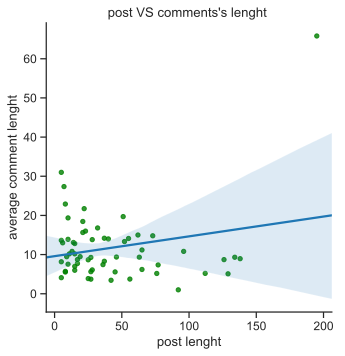

In [225]:
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
sns.lmplot('x', 'y', data=df, fit_reg=True,  scatter_kws={"marker": "D", "s": 19, 'color':'green'})
plt.title("post VS comments's lenght ")
plt.xlabel('post lenght')
plt.ylabel('average comment lenght')

No relation, so, the lenght of the average comment does not depend on the lenght of the post

The next plot is going to reflect the relation between the day od the week and the average post lenght